In [1]:
import psycopg2

In [2]:
conn=psycopg2.connect(host='localhost',database='postgres',user='postgres',password='S71c1gv6z9')

In [3]:
from configparser import ConfigParser
 
def config(filename='database.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
 
    # get section, default to postgresql
    db = {}
    
    # Checks to see if section (postgresql) parser exists
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
         
    # Returns an error if a parameter is called that is not listed in the initialization file
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db


In [4]:
 #This Python script connects to a PostgreSQL database and utilizes Pandas to obtain data and create a data frame
# A initialization and configuration file is used to protect the author's login credentials

import psycopg2
import pandas as pd

# Import the 'config' funtion from the config.py file

# Establish a connection to the database by creating a cursor object

# Obtain the configuration parameters
# params = config()reate_pandas_table(sql_query, database = conn)
# Connect to the PostgreSQL database
# conn = psycopg2.connect(**params)
# Create a new cursor
cur = conn.cursor()

# A function that takes in a PostgreSQL query and outputs a pandas database 
def create_pandas_table(sql_query, database = conn):
    table = pd.read_sql_query(sql_query, database)
    return table
  
# Utilize the create_pandas_table function to create a Pandas data frame
# Store the data as a variable
vendor_info = create_pandas_table(("select c.type, c.details, c.time,c.category, l.coordinates, l.neighborhood, l.address, l.city,d.date from crime c inner join facttable f on c.crime_key=f.crime_key inner join location l on l.location_key=f.location_key inner join date d on d.date_key=f.date_key"))
df=vendor_info

# Close the cursor and connection to so the server can allocate
# bandwidth to other requests
cur.close()
conn.close()

In [5]:
import numpy as np
import math
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
import time
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from matplotlib.patches import Ellipse
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [6]:
# the null values of type are replaced by the details as those crimes exist in Denver 
df.at[df['type'].isnull(),'type'] = df.loc[df['type'].isnull(),'details']

In [9]:
df=df[['category','type', 'neighborhood','city']]
df_copy=df.copy()

In [10]:
le = LabelEncoder()
for col in df.columns[df.dtypes == 'object']:
    df[col] = le.fit_transform(df[col])

In [11]:
df.head()

,category,type,neighborhood,city
0,2,13,50,0
1,2,10,96,1
2,2,3,51,0
3,1,8,27,0
4,1,5,11,1


In [14]:
# choose between 2 clusters to 30 clusters
iner = []

for k in np.arange(2,31):
    kmc = KMeans(n_clusters=k)
    kmc.fit(df)
    preds=kmc.predict(df)
    iner.append(kmc.inertia_)

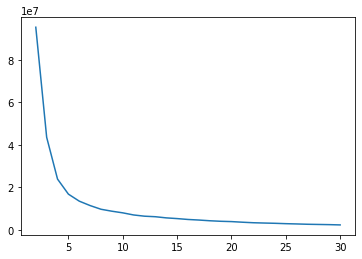

In [15]:
plt.plot(np.arange(2,31),iner)

In [49]:
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
km_silhouette = []
for i in range(4,7):

    silhouette = silhouette_score(df,preds)
    km_silhouette.append(silhouette)

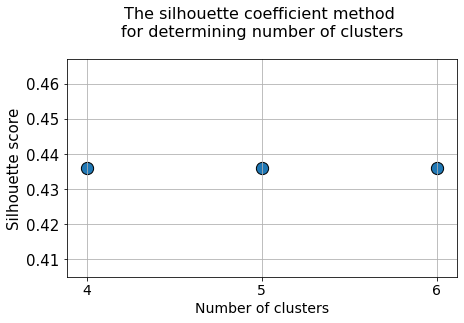

In [50]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(4,7)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(4,7)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [34]:
KMc = KMeans(n_clusters=6)

In [35]:
df_pb = df_copy.copy()
df_pb['Cluster'] = KMc.fit_predict(df)

In [36]:
centers = []

for c in KMc.cluster_centers_:
    centers.append(c.max())

In [37]:
centers = centers / np.max(centers)

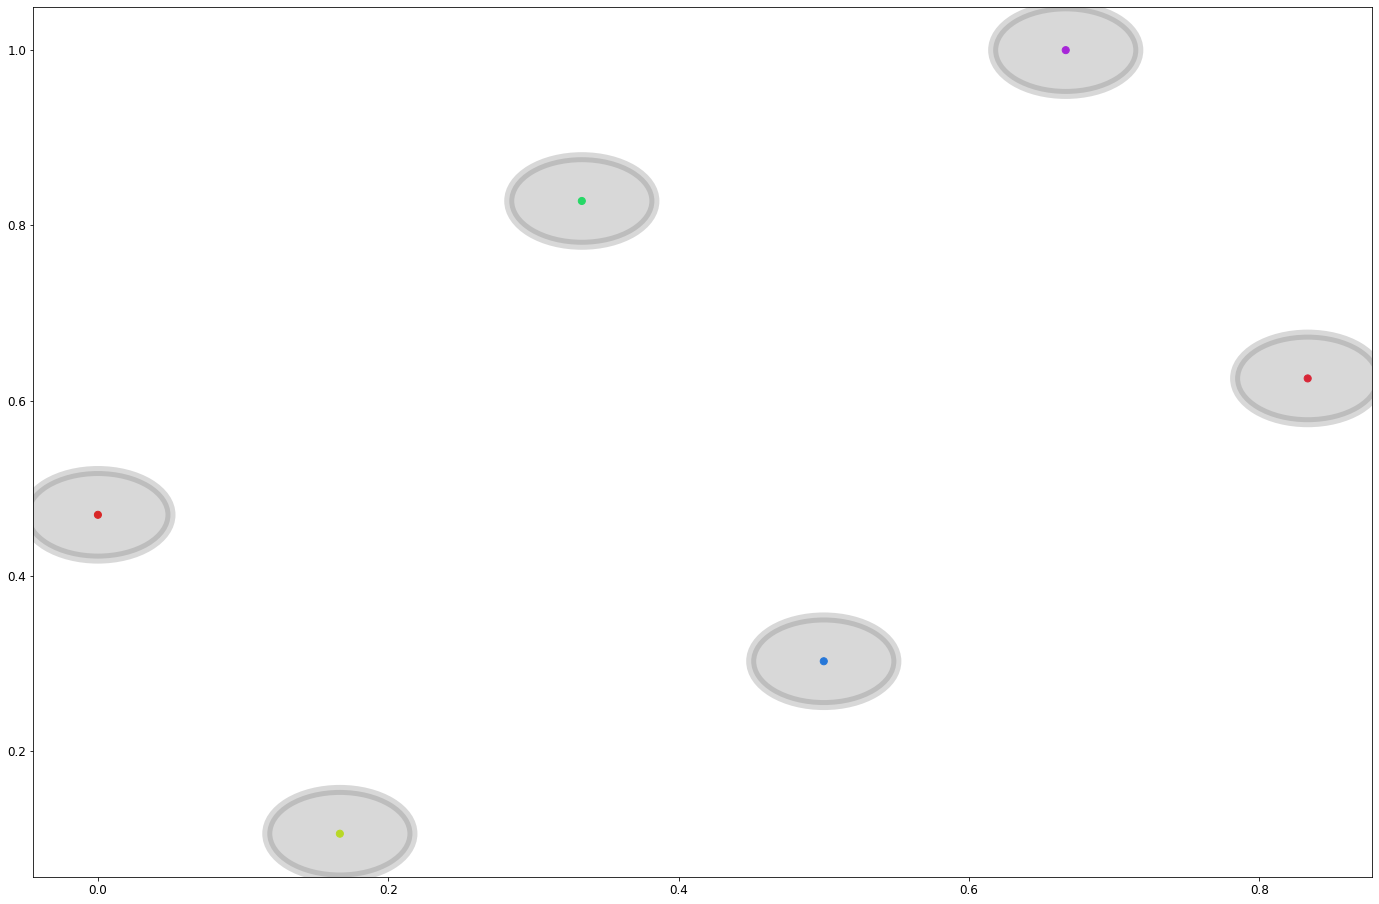

In [38]:
plt.figure(figsize=(24,16))
plt.scatter(np.arange(0,6)/6,centers,c = np.unique(KMc.labels_),cmap='hsv',marker = '.',s=200)
for i,c in enumerate(centers):
    plt.gcf().gca().add_artist(plt.Circle( (i/6,c), radius=.05,alpha=0.3,color='grey',linestyle='-',linewidth=10) )

In [43]:
res = df_pb.drop(columns=['category','city']).groupby('Cluster').agg(lambda x: ', '.join(set(x)))

In [44]:
for i,r in res.iterrows():
    print('\n\nIn cluster ',i,', we have')
    print('\nNeighborhood: \n')
    print(r['neighborhood'])
    print('\nCrime Type: \n')
    print(r['type'])



In cluster  0 , we have

Neighborhood: 

lincoln park, hilltop, indian creek, kerrisdale, lowry field, kitsilano, killarney, harvey park south, jefferson park, kennedy, kensington cedar cottage, highland, hampden south, hastings sunrise, harvey park

Crime Type: 

Break and Enter Commercial, Vehicle Collision or Pedestrian Struck (with Injury), drug-alcohol, Break and Enter Residential/Other, Offence Against a Person, Mischief, all-other-crimes, white-collar-crime, Vehicle Collision or Pedestrian Struck (with Fatality), arson, Theft of Vehicle, Theft of Bicycle, Homicide, Theft from Vehicle, Other Theft


In cluster  1 , we have

Neighborhood: 

cbd, city park, clayton, berkeley, cole, cherry creek, barnum, belcaro, bear valley, baker, city park west, chaffee park, barnum west, civic center, arbutus ridge, central business district, cheesman park, capitol hill, athmar park, auraria

Crime Type: 

Break and Enter Commercial, Vehicle Collision or Pedestrian Struck (with Injury), drug-a

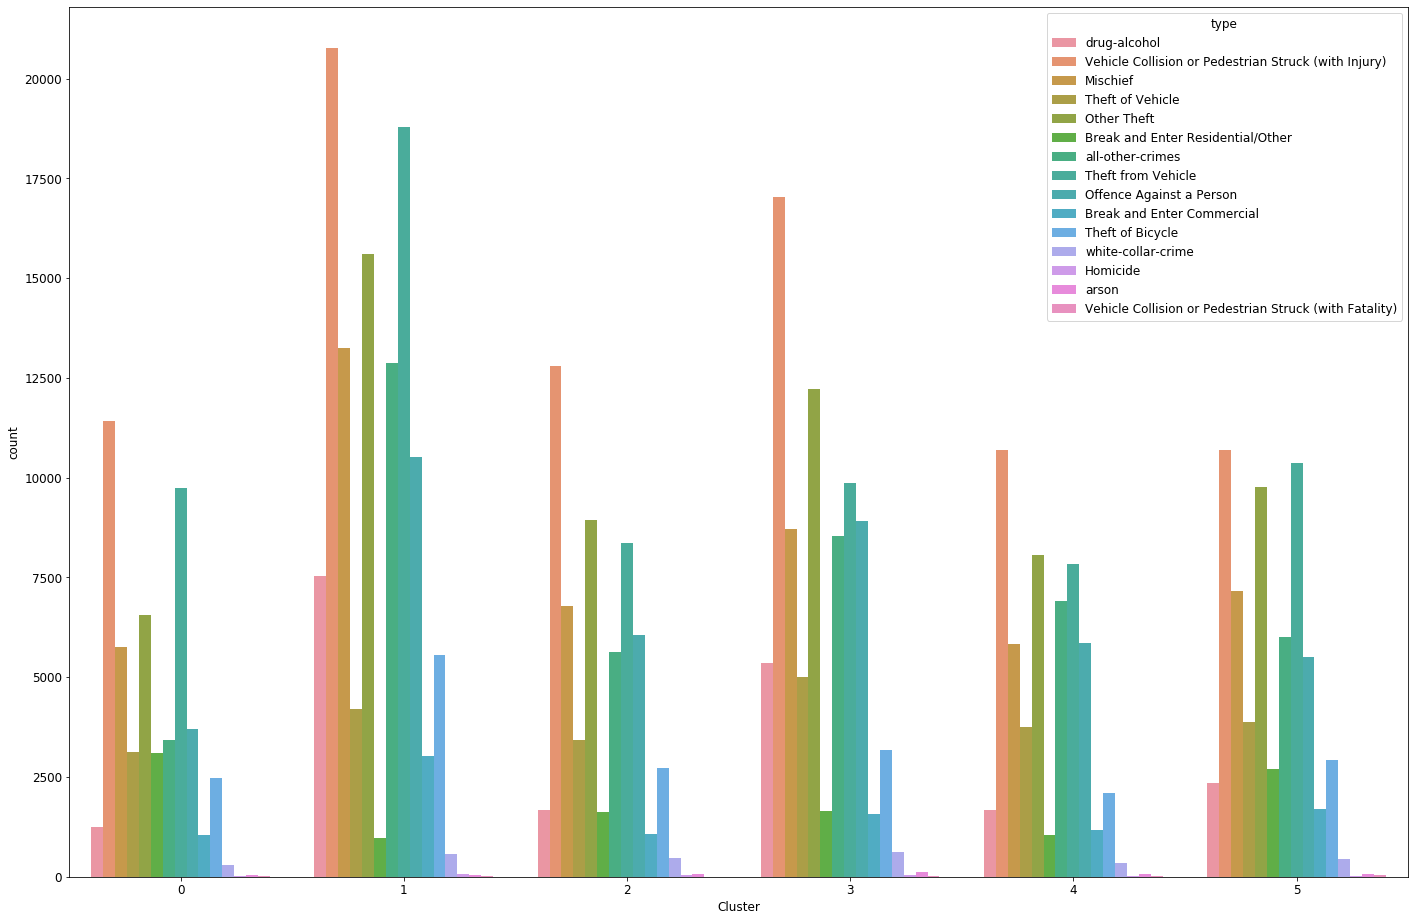

In [45]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(24,16))
plt.xlabel('Clusters')
plt.ylabel('Counts')
sns.countplot(df_pb['Cluster'],hue = df_pb['type'])

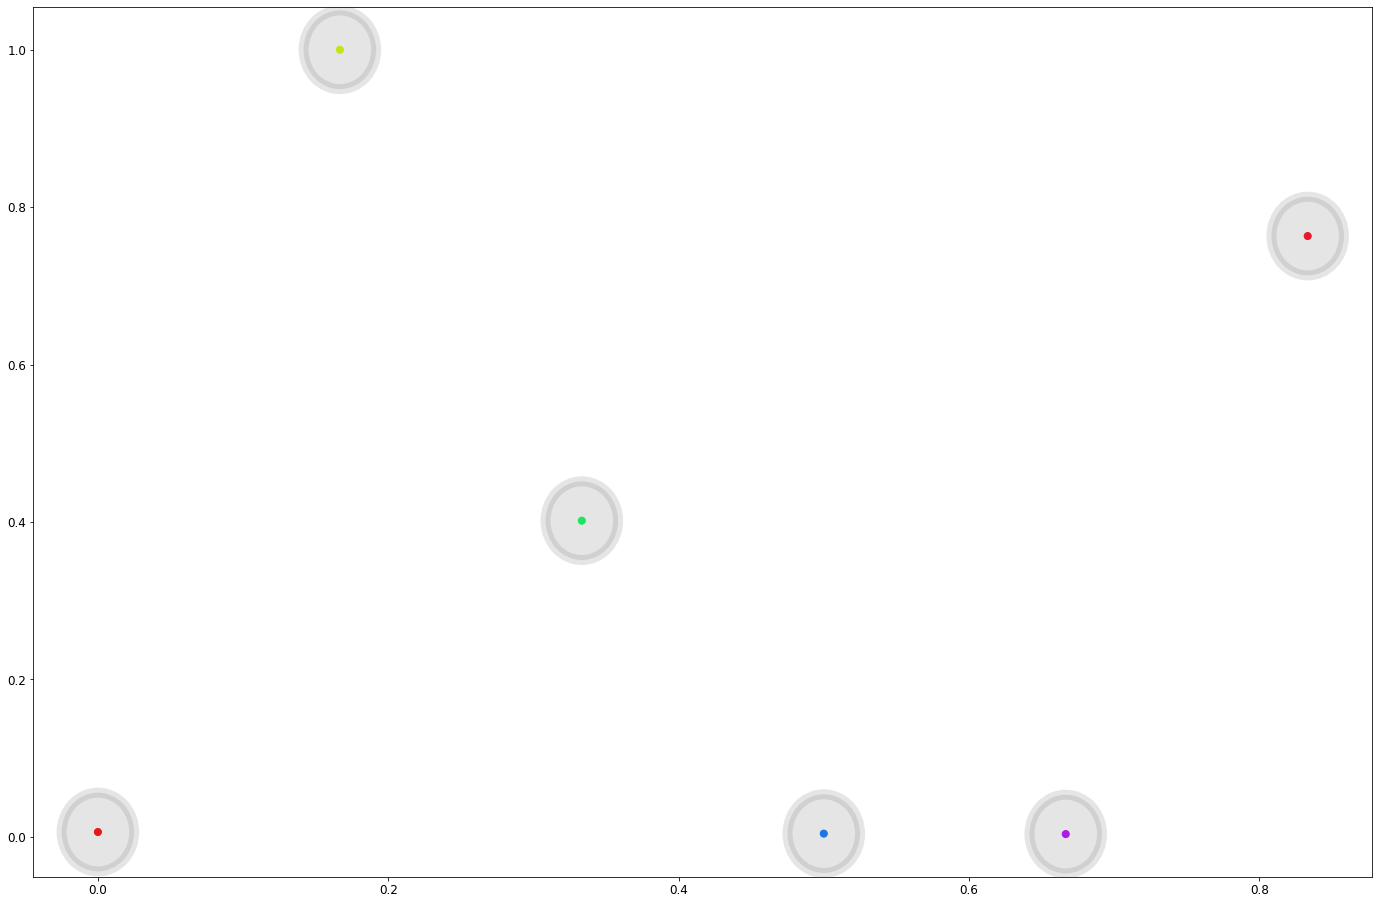

In [29]:
gmm = GaussianMixture(n_components=6)
clusters = gmm.fit_predict(df)
df_mb = df_copy.copy()
df_mb['Cluster'] = clusters


# df_mb.head()
centers = []

for c in gmm.covariances_:
    centers.append(c.mean())
plt.figure(figsize=(24,16))
centers = centers / np.max(centers)
plt.scatter(np.arange(0,6)/6,centers,c = np.arange(0,6),cmap='hsv',marker = '.',s=200)
for i,c in enumerate(centers):
    plt.gcf().gca().add_artist(Ellipse( (i/6,c), width=0.05,height=0.1,color='grey',
                                       linestyle='-',linewidth=10,alpha=0.2) )

In [30]:
res = df_mb.drop(columns=['category','city']).groupby('Cluster').agg(lambda x: ', '.join(set(x)))df_pb

In [31]:
for i,r in res.iterrows():
    print('\n\nIn cluster ',i,', we have')
    print('\nNeighborhood: \n')
    print(r['neighborhood'])
    print('\nCrime Type: \n')
    print(r['type'])



In cluster  0 , we have

Neighborhood: 

strathcona, stanley park, sunset

Crime Type: 

Mischief, Break and Enter Commercial, Break and Enter Residential/Other


In cluster  1 , we have

Neighborhood: 

cbd, wellshire, northeast park hill, berkeley, north capitol hill, windsor, westwood, sloan lake, virginia village, rosedale, harvey park, west highland, baker, sunnyside, west colfax, washington virginia vale, five points, capitol hill, auraria, lincoln park, south park hill, skyland, clayton, highland, globeville, montclair, university hills, cole, cherry creek, hale, belcaro, villa park, east colfax, dia, hampden, indian creek, jefferson park, city park west, north park hill, hilltop, platt park, cheesman park, athmar park, university, ruby hill, city park, lowry field, harvey park south, hampden south, cory merrill, union station, barnum, stapleton, gateway green valley ranch, washington park west, whittier, marston, overland, montbello, university park, kennedy, southmoor park, 

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(24,16))
plt.xlabel('Clusters')
plt.ylabel('Counts')
sns.countplot(df_mb['Cluster'],hue = df_mb['type'])

In [46]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

class clust():
    def _load_data(self, sklearn_load_ds):
        data = sklearn_load_ds
        X = pd.DataFrame(data.data)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, data.target, test_size=0.3, random_state=42)
        
    def __init__(self, sklearn_load_ds):
        self._load_data(sklearn_load_ds)
    
    @timeit
    def classify(self, model=LogisticRegression(random_state=42,max_iter=10000)):
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print('Accuracy: {}'.format(accuracy_score(y_pred,self.y_test)))
        print('Confusion Matrix: \n',confusion_matrix(y_pred,self.y_test))
        
    @timeit
    def Kmeans(self, output='add'):
        n_clusters = len(np.unique(self.y_train))
        clf = KMeans(n_clusters = n_clusters, random_state=42)
        clf.fit(self.X_train)
        y_labels_train = clf.labels_
        y_labels_test = clf.predict(self.X_test)
        if output == 'add':
            self.X_train['km_clust'] = y_labels_train
            self.X_test['km_clust'] = y_labels_test
        elif output == 'replace':
            self.X_train = y_labels_train[:, np.newaxis]
            self.X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self
    @timeit
    def GMM(self, output='add'):
        n_clusters = len(np.unique(self.y_train))
        clf = GaussianMixture(n_components = n_clusters, random_state=42)
        y_labels_train = clf.fit_predict(self.X_train)
        y_labels_test = clf.predict(self.X_test)
        if output == 'add':
            self.X_train['km_clust'] = y_labels_train
            self.X_test['km_clust'] = y_labels_test
        elif output == 'replace':
            self.X_train = y_labels_train[:, np.newaxis]
            self.X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self

In [47]:
clust(load_digits()).Kmeans(output='add').classify()

'Kmeans'  115.69 ms
Accuracy: 0.9629629629629629
Confusion Matrix: 
 [[52  0  0  0  0  0  0  0  0  0]
 [ 0 47  0  0  0  1  0  0  1  0]
 [ 0  0 47  0  0  1  0  0  0  0]
 [ 0  0  0 52  0  0  0  0  0  2]
 [ 1  0  0  0 60  0  0  0  0  0]
 [ 0  0  0  1  0 62  1  0  1  0]
 [ 0  0  0  0  0  1 52  0  0  0]
 [ 0  0  0  0  0  1  0 54  0  0]
 [ 0  3  0  1  0  0  0  0 41  4]
 [ 0  0  0  0  0  0  0  1  0 53]]
'classify'  141.62 ms


C:\Users\zemdy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zemdy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [48]:
clust(load_digits()).GMM(output='add').classify()

'GMM'  148.60 ms
Accuracy: 0.9537037037037037
Confusion Matrix: 
 [[53  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  1  2  0  0  1  0]
 [ 0  1 47  0  0  1  0  0  0  0]
 [ 0  0  0 51  0  0  0  0  0  1]
 [ 0  0  0  0 59  0  0  0  0  0]
 [ 0  0  0  1  0 61  1  0  1  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  0  0  0  0  1  0 54  0  0]
 [ 0  6  0  2  0  1  0  0 41  4]
 [ 0  0  0  0  0  0  0  1  0 54]]
'classify'  108.71 ms


C:\Users\zemdy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zemdy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
